# Real-time Webcam to ASL Translation

Model - combination of a 1D CNN and a Transformer, and used 4x seed ensemble for submission
From: https://github.com/hoyso48/Google---Isolated-Sign-Language-Recognition-1st-place-solution

Latency: 17ms

Accuracy: 89.29%

Set a 5 second buffer to mimic the length of data in the training set

In [6]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import tensorflow as tf
import json

ROWS_PER_FRAME = 543  # number of holistic landmarks
data_columns = 3  # 'x', 'y', 'z' for each landmark
BUFFER_SIZE = 5  # number of frames to buffer before making a prediction

mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

holistic = mp_holistic.Holistic(static_image_mode=False, 
                                min_detection_confidence=0.5, 
                                min_tracking_confidence=0.5)


interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def load_label_map(json_file_path):
    with open(json_file_path, 'r') as file:
        label_map = json.load(file)
    index_to_label = {v: k for k, v in label_map.items()}
    return index_to_label

index_to_label = load_label_map("sign_to_prediction_index_map.json")

In [7]:
def extract_landmarks(results):
    landmarks = {'face': results.face_landmarks, 'left_hand': results.left_hand_landmarks,
                 'pose': results.pose_landmarks, 'right_hand': results.right_hand_landmarks}
    all_landmarks = []
    for key, result in landmarks.items():
        num_landmarks = {'face': 468, 'left_hand': 21, 'pose': 33, 'right_hand': 21}[key]
        if result is None:
            all_landmarks.extend([(0, 0, 0)] * num_landmarks)
        else:
            all_landmarks.extend([(landmark.x, landmark.y, landmark.z) for landmark in result.landmark])
    return all_landmarks

def update_buffer(landmarks_buffer, new_landmarks, buffer_size):
    landmarks_buffer.append(new_landmarks)
    if len(landmarks_buffer) > buffer_size:
        landmarks_buffer.pop(0)
    
    return landmarks_buffer

In [19]:
def get_confidence_level(scores):
    sorted_scores = np.sort(scores)[::-1]  # Sort scores in descending order
    top_score, second_top_score = sorted_scores[:2]  # Get top two scores
    
    # Calculate the difference between the top two scores
    score_difference = top_score - second_top_score
    print(score_difference)
    
    # Define thresholds for high and medium confidence levels
    high_confidence_threshold = 0.2  # Example threshold, adjust based on your model's output
    medium_confidence_threshold = 0.1  # Example threshold, adjust as needed
    
    if score_difference >= high_confidence_threshold:
        return "High"
    elif score_difference >= medium_confidence_threshold:
        return "Medium"
    else:
        return "Low"


In [32]:
landmarks_buffer = []
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(frame_rgb)
    
    mp_drawing.draw_landmarks(
        frame,
        results.face_landmarks,
        mp_holistic.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())
    mp_drawing.draw_landmarks(
        frame,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    mp_drawing.draw_landmarks(
        frame,
        results.left_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
    mp_drawing.draw_landmarks(
        frame,
        results.right_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())

    landmarks = extract_landmarks(results)
    landmarks_buffer = update_buffer(landmarks_buffer, landmarks, BUFFER_SIZE)
    predicted_label = None
    labels = None
    confidence = None
    if len(landmarks_buffer) == BUFFER_SIZE:
        flat_list = [item for sublist in landmarks_buffer for item in sublist]
        df = pd.DataFrame(flat_list, columns = ['x', 'y', 'z'])
        n_frames = int(len(df) / ROWS_PER_FRAME)
        df = df.values.reshape(n_frames, ROWS_PER_FRAME, len(df.columns))
        df = df.astype(np.float32)
        prediction_fcn = interpreter.get_signature_runner('serving_default')
        output = prediction_fcn(inputs=df)
        p = output['outputs'].reshape(-1)
        # softmax normalization 
        p_normalized = np.exp(p) / np.sum(np.exp(p))
        predicted_index = np.argmax(p)
        # second highest prediction label
        second_highest_index = np.argsort(p)[-2]
        second_highest_label = index_to_label[second_highest_index]
        second_confidence = p_normalized[second_highest_index]

        confidence = p_normalized[predicted_index]

        predicted_label = index_to_label[predicted_index]

    cv2.putText(frame, f'Prediction: {predicted_label}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)
    if confidence is not None:
        cv2.putText(frame, f'Confidence: {confidence:.2f}', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frame, f'Second: {second_highest_label} Confidence {second_confidence:.2f}', (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('ASL Word Translation', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [27]:

data ="""-1.296622    0.13980769 -0.45853558 -0.0638537   0.17405821 -0.08182765
  1.1676394  -0.04605046 -1.2292217   0.24838859 -0.27636266 -1.3169947
 -0.5451228  -0.49644098 -0.28485242 -0.46929073  1.2959865  -0.03399964
 -0.23918244 -1.778879    0.78229403  0.5789005   0.43557808 -0.17351125
  1.6802369  -0.66959256 -0.5179271  -1.0020381  -0.22391029  0.2858583
  0.5253151  -0.62055963 -1.4696258  -0.82062185 -0.7980602   0.02467797
 -0.04854628 -0.81159806 -0.05599681 -1.2512879  -0.03096066 -1.0973498
  1.0054945  -0.14496362  0.26406437 -0.7315726  -0.10150015 -0.76628506
  2.730956   -0.52194214  1.3187736   0.48470163 -1.4849612  -0.620323
 -0.6412717   1.220474    0.29974422 -0.8257832   0.45687827 -0.88296914
  0.72481954  1.4327909   0.16882712 -0.8965296   0.36642104 -0.14173172
 -0.36616468 -0.8668062  -0.46955138 -0.7744824  -1.1971395  -1.2301888
 -0.8931159  -0.33952957 -0.05034824 -0.98367536 -0.28016084 -0.9529367
 -0.04742609 -0.68668336 -0.84843117 -0.80814385  0.19787101 -0.1724593
 -1.2093713   1.4381374  -0.7739113  -0.14704117 -0.70996267 -0.79247946
 -0.8126886   2.8646634  -0.27860084  3.1863022  -1.1238192   0.2849188
  1.0790452   0.97766    -0.18942751 -1.4097835   0.9150772  -0.5431912
 -0.45207742 -1.0023952   2.366514   -0.53639925  3.3713207  -0.6377352
  0.04878043  0.14600913  1.5753736  -0.95493376  0.18003856  0.59094626
  0.03766292 -0.5337505  -0.46053392  2.8544016   0.0957585   0.302138
  0.10348224  0.20184141 -1.133935   -0.5938281   0.16753587 -0.38679358
 -0.51396775 -0.4950329  -0.2671931  -1.012235    2.1406662  -0.18109499
 -0.41956088  4.204661   -0.42132667 -0.80665743 -1.0530288   0.13576147
  0.9194639  -1.5001024   0.287707   -0.61925036 -1.0893669  -0.8781951
 -0.5309612  -1.3086199   0.41170883  1.2589774  -1.7098306  -0.30437198
 -0.59215075 -0.7098776   1.6715914  -0.22921532 -0.01163328 -0.86955285
  0.07546542  0.28247327 -0.7557712  -0.54090303 -0.24959517  0.8127039
 -0.9177105   2.58396    -0.1597461   0.40303242 -0.61809194 -0.73723006
 -0.71769226 -0.5344534  -0.8255931  -1.1508234  -1.5927819  -1.0585457
 -0.36448202 -0.6133266  -0.48853078 -1.0880411  -0.5525235  -0.54702437
 -0.42550805 -0.5436865   0.68513334  0.29580504 -1.34414    -1.0115668
 -0.94847196 -0.5455046  -0.7580995  -0.18127196 -0.9609127  -0.29736584
 -0.7586367  -1.2841607   0.06347858  0.48886365 -0.8636073   3.4495075
  1.0958251  -0.5631903  -0.8885497  -0.448938   -1.0106096  -1.1226568
  0.56742513 -0.4926248  -1.2577802   1.8048764  -0.83020043  0.08947808
  3.452993   -0.63608164 -0.06116403 -1.2190514   0.11537451 -0.28083584
  1.0056405  -0.07771929 -0.5745089   0.6609683  -0.30320305 -1.3581914
 -0.267185   -0.44660243 -1.4290498  -0.9297228  -0.8358159   1.0165695
  0.22235776 -0.89750427  0.197238    0.32356188 -1.1673576  -1.4450699
 -1.2274121  -0.70122266 -1.0759057  -0.55314684 -0.60941523 -0.11499252
  0.60284656 -1.0290416  -0.53032595 -0.9348487  -1.1576427  -0.12316771
 -1.4713465  -0.48538974 -0.36790335 -0.387644"""
# Convert the data array to a list
data_list = data.split()

# Convert the list elements to strings and join them with commas
data_str = ', '.join(map(str, data_list))

print(data_str)
#convert the string to an array
data_array = np.array(data_list)
data_array


-1.296622, 0.13980769, -0.45853558, -0.0638537, 0.17405821, -0.08182765, 1.1676394, -0.04605046, -1.2292217, 0.24838859, -0.27636266, -1.3169947, -0.5451228, -0.49644098, -0.28485242, -0.46929073, 1.2959865, -0.03399964, -0.23918244, -1.778879, 0.78229403, 0.5789005, 0.43557808, -0.17351125, 1.6802369, -0.66959256, -0.5179271, -1.0020381, -0.22391029, 0.2858583, 0.5253151, -0.62055963, -1.4696258, -0.82062185, -0.7980602, 0.02467797, -0.04854628, -0.81159806, -0.05599681, -1.2512879, -0.03096066, -1.0973498, 1.0054945, -0.14496362, 0.26406437, -0.7315726, -0.10150015, -0.76628506, 2.730956, -0.52194214, 1.3187736, 0.48470163, -1.4849612, -0.620323, -0.6412717, 1.220474, 0.29974422, -0.8257832, 0.45687827, -0.88296914, 0.72481954, 1.4327909, 0.16882712, -0.8965296, 0.36642104, -0.14173172, -0.36616468, -0.8668062, -0.46955138, -0.7744824, -1.1971395, -1.2301888, -0.8931159, -0.33952957, -0.05034824, -0.98367536, -0.28016084, -0.9529367, -0.04742609, -0.68668336, -0.84843117, -0.80814385

array(['-1.296622', '0.13980769', '-0.45853558', '-0.0638537',
       '0.17405821', '-0.08182765', '1.1676394', '-0.04605046',
       '-1.2292217', '0.24838859', '-0.27636266', '-1.3169947',
       '-0.5451228', '-0.49644098', '-0.28485242', '-0.46929073',
       '1.2959865', '-0.03399964', '-0.23918244', '-1.778879',
       '0.78229403', '0.5789005', '0.43557808', '-0.17351125',
       '1.6802369', '-0.66959256', '-0.5179271', '-1.0020381',
       '-0.22391029', '0.2858583', '0.5253151', '-0.62055963',
       '-1.4696258', '-0.82062185', '-0.7980602', '0.02467797',
       '-0.04854628', '-0.81159806', '-0.05599681', '-1.2512879',
       '-0.03096066', '-1.0973498', '1.0054945', '-0.14496362',
       '0.26406437', '-0.7315726', '-0.10150015', '-0.76628506',
       '2.730956', '-0.52194214', '1.3187736', '0.48470163', '-1.4849612',
       '-0.620323', '-0.6412717', '1.220474', '0.29974422', '-0.8257832',
       '0.45687827', '-0.88296914', '0.72481954', '1.4327909',
       '0.16882712',

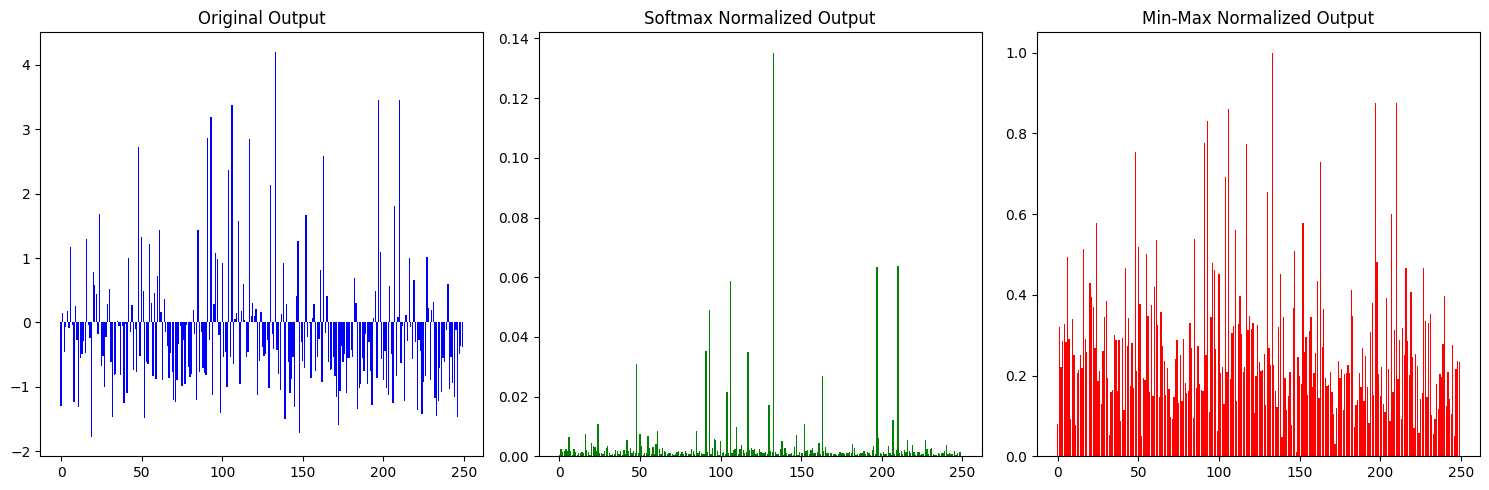

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Define the softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# Define the min-max normalization function
def min_max_normalization(x):
    min_x = np.min(x)
    max_x = np.max(x)
    return (x - min_x) / (max_x - min_x)

output = data_array.astype(np.float32)
# Apply normalization functions
softmax_normalized_output = softmax(output)
min_max_normalized_output = min_max_normalization(output)

# Plotting
plt.figure(figsize=(15, 5))

# Original data
plt.subplot(1, 3, 1)
plt.bar(range(len(output)), output, color='blue')
plt.title('Original Output')

# Softmax-normalized data
plt.subplot(1, 3, 2)
plt.bar(range(len(output)), softmax_normalized_output, color='green')
plt.title('Softmax Normalized Output')

# Min-max-normalized data
plt.subplot(1, 3, 3)
plt.bar(range(len(output)), min_max_normalized_output, color='red')
plt.title('Min-Max Normalized Output')

plt.tight_layout()
plt.show()
